In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importing the dataset

In [4]:
df=pd.read_csv('/content/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Exploring the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
## Checking for the null values

df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [7]:
## Checking for the duplicated data

df.duplicated().sum()

np.int64(0)

In [8]:
## Checking the distribution of the duplicate and non duplicated question

(df['is_duplicate'].value_counts()/df.shape[0])*100

,count
is_duplicate,
0,63.080215
1,36.919785


<Axes: xlabel='is_duplicate', ylabel='count'>

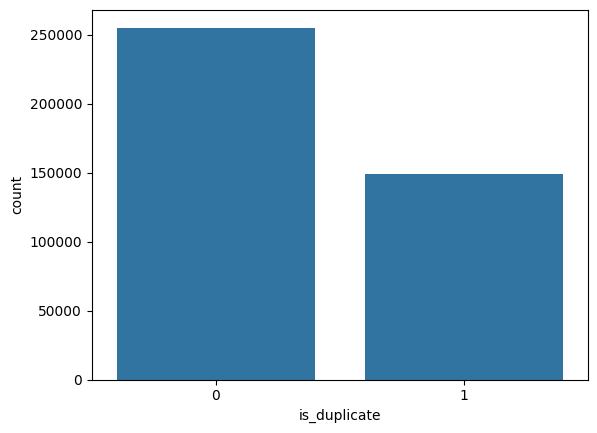

In [9]:
sns.countplot(data=df,x='is_duplicate')   ## Data is baised towards class )

In [10]:
## Checking for the count of repeated and unique questions

qids=pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of Unique question ids is ', np.unique(qids).shape[0])

x=qids.value_counts()>1
print('Number of questions that are repeated is ', x[x].shape[0])


Number of Unique question ids is  537933
Number of questions that are repeated is  111780


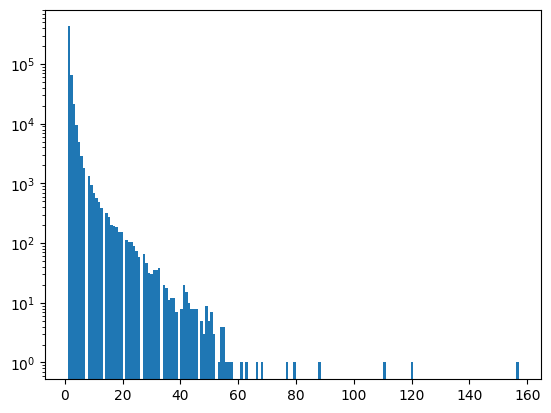

In [11]:
## Visualizing the count of repeated questions using the histogram

plt.hist(qids.value_counts().values,bins=180)
plt.yscale('log')
plt.show()

# Approach 1 : Apply BOWs directly and use the ML model

In [12]:
new_df=df.sample(30000)

new_df.isnull().sum(), new_df.duplicated().sum()

(id              0
 qid1            0
 qid2            0
 question1       0
 question2       0
 is_duplicate    0
 dtype: int64,
 np.int64(0))

In [13]:
questions_df=new_df[['question1','question2']]
questions_df.head()

,question1,question2
1362,How can I learn node.js in a week?,What is the best way of learning Node.js?
195457,What is the process of buying shares and minim...,What is the minimum amount for buying shares?
313661,What did you try once and will never try again?,What is something you tried but never do again?
41628,What are some good websites where you can post...,What is a logo design I can use for a movie re...
359669,Why aren't terrorists portrayed as cowards by ...,Would you like to enter the Polish market with...


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(max_features=3000)  # This will keep only 3000 unique words

ques=list(questions_df['question1'])+list(questions_df['question2'])

ques1_arr,ques2_arr=np.vsplit(cv.fit_transform(ques).toarray(),2)

In [15]:
temp_df1=pd.DataFrame(ques1_arr,index=questions_df.index)
temp_df2=pd.DataFrame(ques2_arr,index=questions_df.index)

temp_df=pd.concat([temp_df1,temp_df2],axis=1)
temp_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
1362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
temp_df['is_duplicate']=new_df['is_duplicate']

In [17]:
temp_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
1362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
## Now directly using the machine learning model on this dataset

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(temp_df.iloc[:,:-1],temp_df.iloc[:,-1],test_size=0.20,random_state=2)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
accuracy_score(y_test,rfc.predict(X_test))

0.7388333333333333

In [21]:
from xgboost import XGBClassifier

xgb=XGBClassifier()
xgb.fit(X_train.values,y_train)

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [22]:
accuracy_score(y_test,xgb.predict(X_test.values))

0.7253333333333334

# Approach 2

## Custom Feature Engineering

* q1_len,q2_len : character len of q1 and q2

* q1_words,q2_words : number of words in q1,q2

* word common : number of common and unique words

* word total : total number of words in q1+q2

* word share : word common/ word total


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df=pd.read_csv('/content/train.csv').sample(30000)

FileNotFoundError: [Errno 2] No such file or directory: '/content/train.csv'

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
## Applying the basic bag of words first

from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(max_features=3000)
ques=list(df['question1'])+list(df['question2'])

q1_arr,q2_arr=np.vsplit(cv.fit_transform(ques).toarray(),2)

In [ ]:
temp_df=pd.concat([pd.DataFrame(q1_arr,index=df.index),pd.DataFrame(q2_arr,index=df.index)],axis=1)
temp_df.head()

In [ ]:
## Generating the features - Feature Engineering

temp=pd.DataFrame()
temp['q1_len']=df['question1'].str.len()
temp['q2_len']=df['question2'].str.len()

In [ ]:
temp.head(1)

Total Number of words in both the questions

In [ ]:
temp['q1_num_words']=df['question1'].apply(lambda row : len(row.split(" ")))
temp['q2_num_words']=df['question2'].apply(lambda row : len(row.split(" ")))
temp.head(1)

Total number of common words which are unique as well

In [ ]:
def find_common_words(row):
  w1=set(map(lambda word : word.lower().strip(),row['question1'].split(" ")))
  w2=set(map(lambda word : word.lower().strip(),row['question2'].split(" ")))
  return len(w1 & w2) # Applying the set operation to get the common words from both the set of words

In [ ]:
temp['common_words']=df.apply(find_common_words,axis=1)
temp.head()

Total number of unique words

In [ ]:
def find_total_Words(row):
  w1=set(map(lambda word : word.lower().strip(),row['question1'].split(" ")))
  w2=set(map(lambda word : word.lower().strip(),row['question2'].split(" ")))
  return (len(w1)+len(w2))

In [ ]:
temp['total_words']=df.apply(find_total_Words,axis=1)
temp.head(2)

Word Share

In [ ]:
temp['word_share']=temp['common_words']/temp['total_words']
temp.head()

In [ ]:
new_df=pd.concat([temp_df,temp],axis=1)

Performing the basic analysis on the features created

In [ ]:
sns.displot(data=new_df,x='q1_len')
print('Maximum Characters in the question 1', new_df['q1_len'].max())
print('Minimum Characters in the question 1', new_df['q1_len'].min())
print('Average Characters in the question 1', new_df['q1_len'].mean())

In [ ]:
sns.displot(data=new_df,x='q2_len')
print('Maximum Characters in the question 2', new_df['q2_len'].max())
print('Minimum Characters in the question 2', new_df['q2_len'].min())
print('Average Characters in the question 2', new_df['q2_len'].mean())

In [ ]:
sns.displot(data=new_df,x='q1_num_words')
print('Maximum Words in the question 1', new_df['q1_num_words'].max())
print('Minimum words in the question 1', new_df['q1_num_words'].min())   # Outlier
print('Average words in the question 1', new_df['q1_num_words'].mean())

In [ ]:
sns.displot(data=new_df,x='q2_num_words')
print('Maximum Words in the question 2', new_df['q2_num_words'].max())
print('Minimum words in the question 2', new_df['q2_num_words'].min())
print('Average words in the question 2', new_df['q2_num_words'].mean())

In [ ]:
sns.displot(data=new_df,x='common_words')
print('Maximum Common Words ', new_df['common_words'].max())
print('Minimum Common words ', new_df['common_words'].min())
print('Average Common words ', new_df['common_words'].mean())

In [ ]:
new_df['is_duplicate']=df['is_duplicate']

In [ ]:
sns.distplot(new_df[new_df['is_duplicate']==0]['common_words'],label='Not Duplicated',kde=True)
sns.distplot(new_df[new_df['is_duplicate']==1]['common_words'],label='Duplicated',kde=True)
plt.legend()
plt.show()

In [ ]:
sns.distplot(new_df[new_df['is_duplicate']==0]['word_share'],label='Not Duplicated Questions',kde=True)
sns.distplot(new_df[new_df['is_duplicate']==1]['word_share'],label='Duplicated Questions',kde=True)

plt.legend()
plt.show()

In [ ]:
sns.distplot(new_df[new_df['is_duplicate']==0]['total_words'],label='Not Duplicated Questions',kde=True)
sns.distplot(new_df[new_df['is_duplicate']==1]['total_words'],label='Duplicated Questions',kde=True)

plt.legend()
plt.show()

In [ ]:
new_df

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(new_df.iloc[:,0:-1],new_df.iloc[:,-1],test_size=0.20,random_state=2)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

xgb=XGBClassifier()
rfc=RandomForestClassifier()

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
rfc.fit(X_train.values,y_train)
accuracy_score(y_test,rfc.predict(X_test.values))

0.7745

In [30]:
xgb.fit(X_train.values,y_train)
accuracy_score(y_test,xgb.predict(X_test.values))

0.768

In [31]:
new_df.to_csv('approach2_feature_engineered_dataset.csv')

## Approach 3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Token Features

* cwc_min and cwc max : the ratio of number of common words to the length of the smaller question and the larger question

* csc_min and csc_max : the ratio of number of common stopwords to the min of stopwords in q1 and q2 and the max of stopwords in q1 and q2 respectively

* ctc_min and ctc_max : the ratio of number of common tokens to the min tokens in q1 and q2 and to the max of stopwords in q1 and q2

* last_word_equal : checks if the last word of both the ques is same or not

* first_word_eqal : checks if the first word is same or not


# Length based features

* mean_len : mean len of the both the ques

* abs_len_diff

* longest_substring_ratio : it the ratio of the longest substring of the questions to the number of tokens of the question having the least number of tokens in it

q1= w1,w2,w3,w4,w1,w2
     
q2=w1,w2,w5,w8,w1

longest_subs=w1,w2=2

number of tokens in the smaller ques=5(q2)

==2/5


## Fuzzy Features from fuzzy-wuzzy library

* fuzz ratio

* fuzz partial ratio

* token sort ratio

* token set ratio

In [3]:
df=pd.read_csv('/content/train.csv').sample(30000)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
123557,123557,199738,102934,How might WhatsApp change after being bought b...,What is the significance of WhatsApp for Faceb...,0
334961,334961,462200,462201,Who are your favourite Quorans whom you don't ...,Recommended Users on Quora: Who are your favou...,0
235304,235304,345992,345993,What is the structural difference between amyl...,WHY India IS BUYING APACHE HELICOPTER FROM USA...,0
253192,253192,52494,40232,What's the big deal about cultural appropriation?,What is cultural appropriation and why is it s...,1
388858,388858,184125,357889,How does it feel to be gay and Christian?,What's it like to be gay and a Christian?,1


Applying text preprocessing

In [4]:
import re

In [5]:
def preprocess(q):

  q=str(q).lower().strip()

  # Replacing certain special characters with their string equivalents
  q=q.replace('%', ' percent')
  q=q.replace('$', ' dollar ')
  q=q.replace('₹', ' rupee ')
  q=q.replace('€', ' euro ')
  q=q.replace('@', ' at ')
  q=q.replace('&','and')

  # The pattern '[math]' appeared in the text several time so we need to replace it
  q=q.replace('[math]','')

  # replacing some numbers with their string equivae=lents
  q=q.replace(',000,000,000 ','b ')
  q=q.replace(',000,000 ','m ')
  q=q.replace(',000 ','k ')
  q=re.sub(r'([0-9]+)000000000',r'\1b',q)
  q=re.sub(r'([0-9]+)000000',r'\1m',q)
  q=re.sub(r'([0-9]+)000',r'\1k',q)


  # Decontracting words

  # Source - https://stackoverflow.com/a/19794953
  # Posted by arturomp, modified by community. See post 'Timeline' for change history
  # Retrieved 2026-02-23, License - CC BY-SA 3.0

  contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he had",
  "he'd've": "he would have",
  "he'll": "he shall",
  "he'll've": "he shall have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how has",
  "I'd": "I had",
  "I'd've": "I would have",
  "I'll": "I shall",
  "I'll've": "I shall have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it shall",
  "it'll've": "it shall have",
  "it's": "it has",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had",
  "she'd've": "she would have",
  "she'll": "she shall",
  "she'll've": "she shall have",
  "she's": "she has",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that has",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there has",
  "they'd": "they had",
  "they'd've": "they would have",
  "they'll": "they shall",
  "they'll've": "they shall have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what shall",
  "what'll've": "what shall have",
  "what're": "what are",
  "what's": "what has",
  "what've": "what have",
  "when's": "when has",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where has",
  "where've": "where have",
  "who'll": "who shall",
  "who'll've": "who shall have",
  "who's": "who has",
  "who've": "who have",
  "why's": "why has",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you shall",
  "you'll've": "you shall have",
  "you're": "you are",
  "you've": "you have"
  }

  decontracted=[]

  for word in q.split():
    if word in contractions:
      word=contractions[word]
    decontracted.append(word)

  q=" ".join(decontracted)

  q=q.replace("'ve",' have')
  q=q.replace("n't",' not')
  q=q.replace("'re",' are')
  q=q.replace("'ll",' will')

  ## Removing html tags using beautiful soup
  from bs4 import BeautifulSoup
  q=BeautifulSoup(q).get_text()

  ## Removing Punctuation

  pattern=re.compile(r'\W')
  q=re.sub(pattern,' ',q).strip()

  return q


In [6]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [7]:
df['question1']=df['question1'].apply(preprocess)
df['question2']=df['question2'].apply(preprocess)

In [8]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
123557,123557,199738,102934,how might whatsapp change after being bought b...,what is the significance of whatsapp for faceb...,0
334961,334961,462200,462201,who are your favourite quorans whom you do not...,recommended users on quora who are your favou...,0


Character len of both the ques

In [9]:
df['q1_len']=df['question1'].str.len()
df['q2_len']=df['question2'].str.len()

Word len

In [10]:
df['q1_num_words']=df['question1'].apply(lambda row : len(row.split(" ")))
df['q2_num_words']=df['question2'].apply(lambda row : len(row.split(" ")))

Common Words

In [11]:
def common_words(row):
  w1=set(map(lambda word : word.lower().strip(),row['question1'].split(" ")))
  w2=set(map(lambda word : word.lower().strip(),row['question2'].split(" ")))
  return len(w1 & w2)

df['common_words']=df.apply(common_words,axis=1)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words
123557,123557,199738,102934,how might whatsapp change after being bought b...,what is the significance of whatsapp for faceb...,0,56,127,9,23,2
334961,334961,462200,462201,who are your favourite quorans whom you do not...,recommended users on quora who are your favou...,0,62,58,11,10,5


total words which are unqiue as well

In [12]:
def find_total_unique_words(row):
  w1=set(map(lambda word : word.lower().strip(),row['question1'].strip()))
  w2=set(map(lambda word : word.lower().strip(),row['question2'].strip()))
  return(len(w1)+len(w2))

df['total_words']=df.apply(find_total_unique_words,axis=1)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words
123557,123557,199738,102934,how might whatsapp change after being bought b...,what is the significance of whatsapp for faceb...,0,56,127,9,23,2,44
334961,334961,462200,462201,who are your favourite quorans whom you do not...,recommended users on quora who are your favou...,0,62,58,11,10,5,39


Word share

In [13]:
df['word share']=df['common_words']/df['total_words']
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word share
123557,123557,199738,102934,how might whatsapp change after being bought b...,what is the significance of whatsapp for faceb...,0,56,127,9,23,2,44,0.045455
334961,334961,462200,462201,who are your favourite quorans whom you do not...,recommended users on quora who are your favou...,0,62,58,11,10,5,39,0.128205
235304,235304,345992,345993,what is the structural difference between amyl...,why india is buying apache helicopter from usa...,0,84,133,14,23,2,42,0.047619
253192,253192,52494,40232,what has the big deal about cultural appropria...,what is cultural appropriation and why is it s...,1,50,63,8,12,4,38,0.105263
388858,388858,184125,357889,how does it feel to be gay and christian,what has it like to be gay and a christian,1,40,42,9,10,6,36,0.166667


In [14]:
## All these features are made on the preprocessed text

## Applying advanced Feature Engineering

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [16]:
def add_token_features(row):
  q1=row['question1']
  q2=row['question2']

  safe_div=0.001

  stop_words=stopwords.words('english')
  token_features=[0.0]*8

  ## Converting the sentences into the tokens
  q1_tokens=word_tokenize(q1)
  q2_tokens=word_tokenize(q2)

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features

  ## Extracting the non stopwords from the questions
  q1_words=set([word for word in q1_tokens if word not in stop_words])
  q2_words=set([word for word in q2_tokens if word not in stop_words])

  ## Extracting the stopwords from the each questions
  q1_stopwords=set([word for word in q1_tokens if word in stop_words])
  q2_stopwords=set([word for word in q2_tokens if word in stop_words])


  ## Extracting the common non_stopwords from the quespairs
  common_word_count=len(set(q1_words).intersection(set(q2_words)))

  ## Extracting the count of common stopwords
  common_stopwords_count=len(set(q1_stopwords).intersection(set(q2_stopwords)))

  ## Extracting the count of common tokens
  common_token_counts=len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0]=common_word_count/(min(len(q1_words),len(q2_words))+safe_div)
  token_features[1]=common_word_count/(max(len(q1_words),len(q2_words))+safe_div)
  token_features[2]=common_stopwords_count/(min(len(q1_stopwords),len(q2_stopwords))+safe_div)
  token_features[3]=common_stopwords_count/(max(len(q1_stopwords),len(q2_stopwords))+safe_div)
  token_features[4]=common_token_counts/(min(len(q1_tokens),len(q2_tokens))+safe_div)
  token_features[5]=common_token_counts/(max(len(q1_tokens),len(q2_tokens))+safe_div)

  ## Check if the last word is same or not
  token_features[6] =int(q1_tokens[-1]==q2_tokens[-1])

  ## Check if the first word is same or not
  token_features[7]=int(q1_tokens[0]==q2_tokens[0])

  return token_features

In [17]:
token_features=df.apply(add_token_features,axis=1)

df['cwc_min']=list(map(lambda x:x[0],token_features))
df['cwc_max']=list(map(lambda x:x[1],token_features))
df['csc_min']=list(map(lambda x:x[2],token_features))
df['csc_max']=list(map(lambda x:x[3],token_features))
df['ctc_min']=list(map(lambda x:x[4],token_features))
df['ctc_max']=list(map(lambda x:x[5],token_features))
df['last_word_equal']=list(map(lambda x:x[6],token_features))
df['first_word_euqal']=list(map(lambda x:x[7],token_features))



In [18]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,total_words,word share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_equal,first_word_euqal
123557,123557,199738,102934,how might whatsapp change after being bought b...,what is the significance of whatsapp for faceb...,0,56,127,9,23,...,44,0.045455,0.399920,0.222198,0.000000,0.000000,0.222198,0.090905,0.0,0.0
334961,334961,462200,462201,who are your favourite quorans whom you do not...,recommended users on quora who are your favou...,0,62,58,11,10,...,39,0.128205,0.499875,0.399920,0.749813,0.428510,0.555494,0.454504,0.0,0.0
235304,235304,345992,345993,what is the structural difference between amyl...,why india is buying apache helicopter from usa...,0,84,133,14,23,...,42,0.047619,0.000000,0.000000,0.249938,0.124984,0.076917,0.049998,0.0,0.0
253192,253192,52494,40232,what has the big deal about cultural appropria...,what is cultural appropriation and why is it s...,1,50,63,8,12,...,38,0.105263,0.749813,0.749813,0.249938,0.142837,0.499938,0.333306,0.0,1.0
388858,388858,184125,357889,how does it feel to be gay and christian,what has it like to be gay and a christian,1,40,42,9,10,...,36,0.166667,0.666445,0.666445,0.666556,0.571347,0.666593,0.599940,1.0,0.0


In [19]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16256 sha256=fc017814bd1143ddf4879af260539df60620b744b8eb3306760f2e583c3e08e4
  Stored in directory: /root/.cache/pip/wheels/24/a8/58/407063d8e5c1d4dd6594c99d12baa0108570b56a92325587dd
Successfully built distance


In [20]:
import distance

def fetch_length_features(row):
  q1=row['question1']
  q2=row['question2']

  len_features=[0.0]*3

  q1_tokens=word_tokenize(q1)
  q2_tokens=word_tokenize(q2)

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return len_features

  ## Absolute length difference
  len_features[0]=abs(len(q1_tokens)-len(q2_tokens))

  ## Average token length of both the questions
  len_features[1]=(len(q1_tokens)+len(q2_tokens))/2


  ## Finding the maximum substring ratio

  strs=list(distance.lcsubstrings(q1,q2))
  len_features[2]=len(strs[0])/min(len(q1_tokens),len(q2_tokens)+1)

  return len_features


In [ ]:
!pip install distance

In [21]:
length_features=df.apply(fetch_length_features,axis=1)

df['abs_len_diff']=list(map(lambda x : x[0],length_features))
df['mean_len']=list(map(lambda x : x[1],length_features))
df['longest_substring_ratio']=list(map(lambda x : x[2],length_features))

In [22]:
!pip install fuzzywuzzy

In [23]:
## Fuzzy features

from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
  q1=row['question1']
  q2=row['question2']

  fuzz_features=[0.0]*4

  # fuzzy ratio
  fuzz_features[0]=fuzz.QRatio(q1,q2)

  # Partial fuzzy ratio
  fuzz_features[1]=fuzz.partial_ratio(q1,q2)

  # token_sort_ratio
  fuzz_features[2]=fuzz.token_sort_ratio(q1,q2)

  ## token_set_ratio
  fuzz_features[3]=fuzz.token_set_ratio(q1,q2)

  return fuzz_features

/usr/local/lib/python3.12/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [24]:
fuzzy_features=df.apply(fetch_fuzzy_features,axis=1)

df['fuzz_ratio']=list(map(lambda x:x[0],fuzzy_features))
df['fuzz_partial_ratio']=list(map(lambda x:x[1],fuzzy_features))
df['token_sort_ratio']=list(map(lambda x:x[2],fuzzy_features))
df['token_set_ratio']=list(map(lambda x:x[3],fuzzy_features))

In [25]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_equal,first_word_euqal,abs_len_diff,mean_len,longest_substring_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
123557,123557,199738,102934,how might whatsapp change after being bought b...,what is the significance of whatsapp for faceb...,0,56,127,9,23,...,0.090905,0.0,0.0,13.0,15.5,1.111111,27,45,37,47
334961,334961,462200,462201,who are your favourite quorans whom you do not...,recommended users on quora who are your favou...,0,62,58,11,10,...,0.454504,0.0,0.0,2.0,10.0,3.000000,50,52,59,69


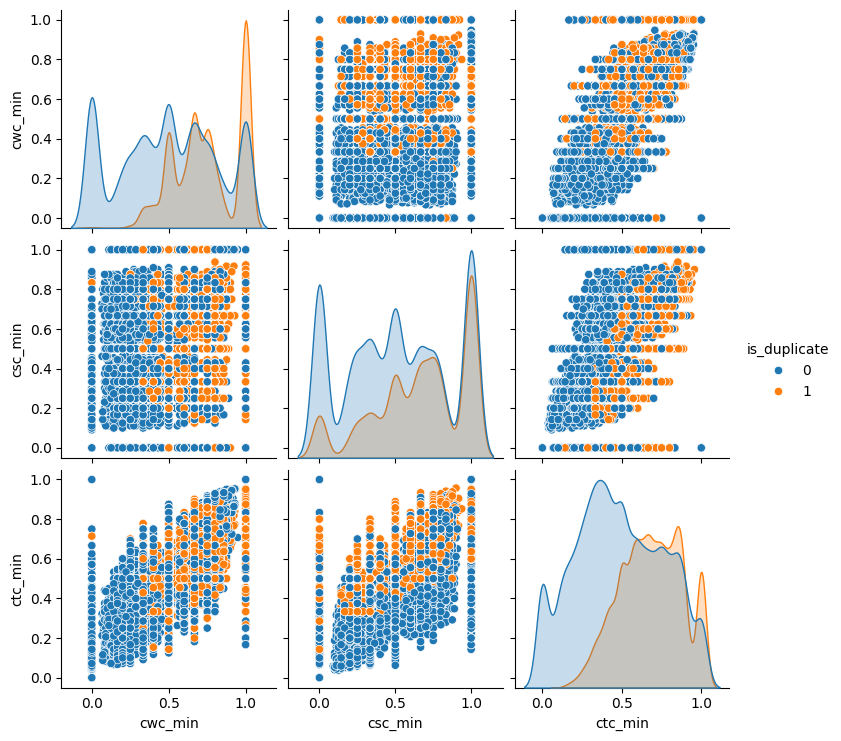

In [34]:
## Performing EDA on the newly crafted features

sns.pairplot(df[['cwc_min','csc_min','ctc_min','is_duplicate']],hue='is_duplicate')

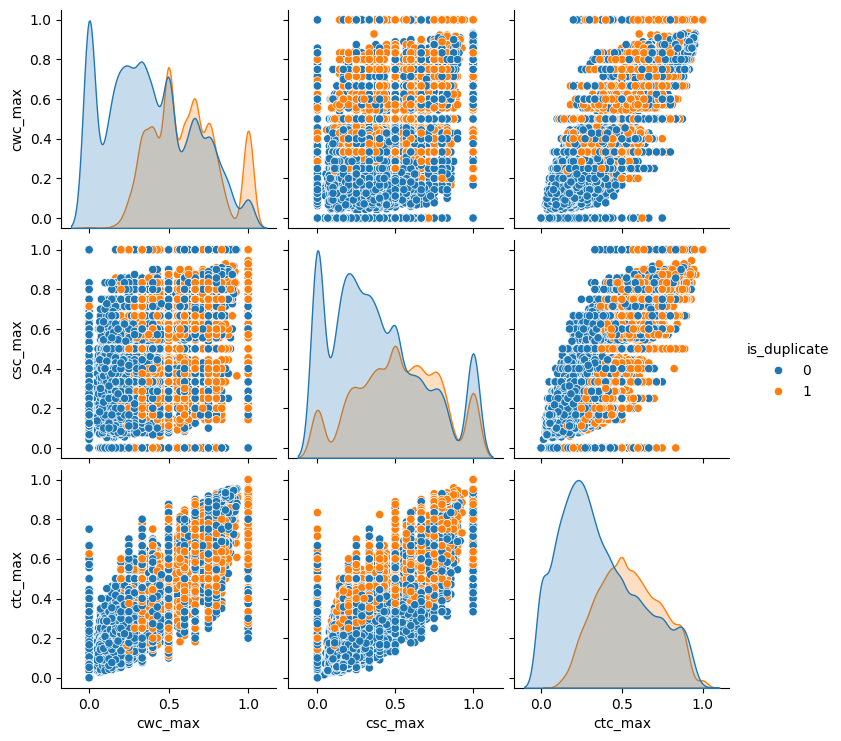

In [35]:
sns.pairplot(df[['cwc_max','csc_max','ctc_max','is_duplicate']],hue='is_duplicate')

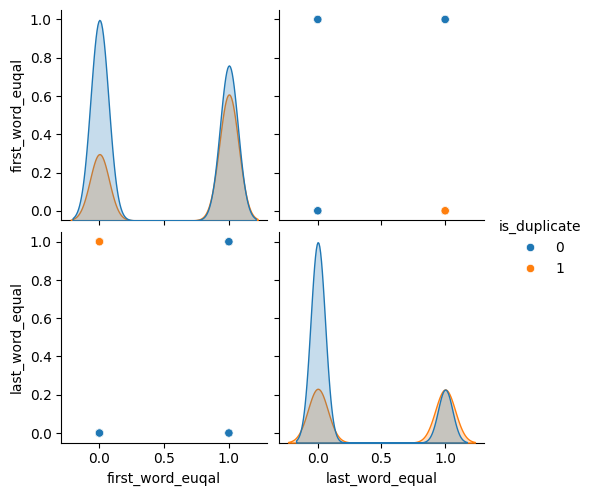

In [36]:
sns.pairplot(df[['first_word_euqal','last_word_equal','is_duplicate']],hue='is_duplicate')

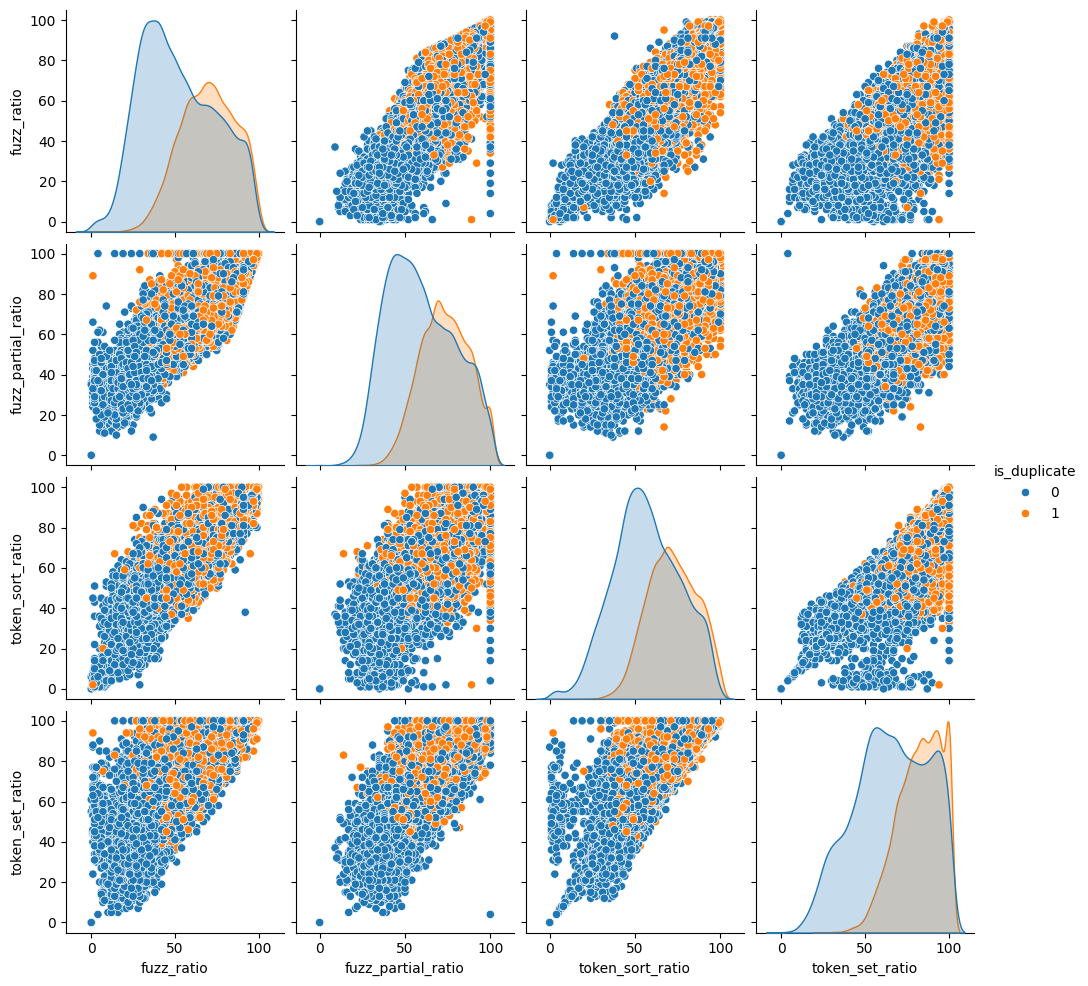

In [37]:
sns.pairplot(df[['fuzz_ratio','fuzz_partial_ratio','token_sort_ratio','token_set_ratio','is_duplicate']],hue='is_duplicate')

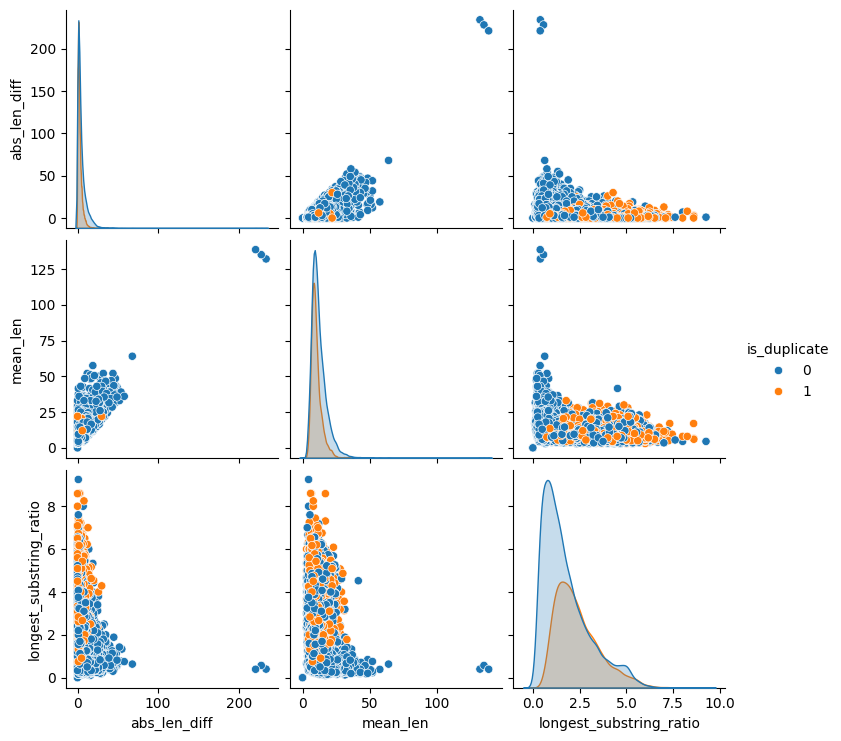

In [38]:
sns.pairplot(df[['abs_len_diff','mean_len','longest_substring_ratio','is_duplicate']],hue='is_duplicate')

In [39]:
## Overall the features constructed are contributing to some extent toward the results

In [26]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'common_words',
       'total_words', 'word share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_equal', 'first_word_euqal',
       'abs_len_diff', 'mean_len', 'longest_substring_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

In [27]:
from sklearn.preprocessing import MinMaxScaler


mms=MinMaxScaler()

x=mms.fit_transform(df[['cwc_min', 'cwc_max', 'csc_min', 'ctc_min','ctc_max', 'last_word_equal', 'first_word_euqal', 'abs_len_diff','mean_len', 'longest_substring_ratio', 'fuzz_ratio','fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'csc_max']])
y=df['is_duplicate'].values

In [90]:
from sklearn.manifold import TSNE

tsne=TSNE(
    n_components=2,
    init='random', # apply pca
    random_state=98,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(x)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.135s...
[t-SNE] Computed neighbors for 30000 samples in 12.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

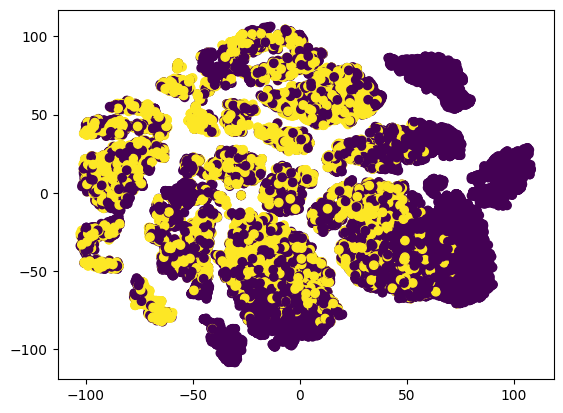

In [94]:
plt.scatter(tsne[:,0],tsne[:,1],c=y)

In [95]:
## This is able to tell the difference in both the different classes to some good extent

In [96]:
tsne=TSNE(
    n_components=3,
    init='random', ## apply pca
    random_state=98,
    method='barnes_hut',
    angle=0.5,
    n_iter=1000,
    verbose=2
).fit_transform(x)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.101s...
[t-SNE] Computed neighbors for 30000 samples in 11.885s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

KeyboardInterrupt: 

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    x=tsne[:, 0],
    y=tsne[:, 1],
    z=tsne[:, 2],
    title="3D t-SNE Visualization",
    color=y
)

fig.show()


In [28]:
ques_df=df[['question1','question2']]

no_ques_df=df.drop(columns=['id','qid1','qid2','question1','question2'])

no_ques_df.head(3)

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word share,cwc_min,cwc_max,...,ctc_max,last_word_equal,first_word_euqal,abs_len_diff,mean_len,longest_substring_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
123557,0,56,127,9,23,2,44,0.045455,0.399920,0.222198,...,0.090905,0.0,0.0,13.0,15.5,1.111111,27,45,37,47
334961,0,62,58,11,10,5,39,0.128205,0.499875,0.399920,...,0.454504,0.0,0.0,2.0,10.0,3.000000,50,52,59,69
235304,0,84,133,14,23,2,42,0.047619,0.000000,0.000000,...,0.049998,0.0,0.0,7.0,16.5,0.307692,29,30,31,35


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(max_features=3000)

ques=list(ques_df['question1'])+list(ques_df['question2'])

q1_arr,q2_arr=np.vsplit(cv.fit_transform(ques).toarray(),2)

In [30]:
temp_df=pd.concat([pd.DataFrame(q1_arr,index=ques_df.index),pd.DataFrame(q2_arr,index=ques_df.index)],axis=1)
temp_df

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
123557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
334961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
235304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
253192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3691,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
final_df=pd.concat([no_ques_df,temp_df],axis=1)
final_df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
123557,0,56,127,9,23,2,44,0.045455,0.399920,0.222198,...,0,0,0,0,0,0,0,0,0,0
334961,0,62,58,11,10,5,39,0.128205,0.499875,0.399920,...,0,0,0,0,1,0,0,0,0,0
235304,0,84,133,14,23,2,42,0.047619,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
253192,1,50,63,8,12,4,38,0.105263,0.749813,0.749813,...,0,0,0,0,0,0,0,0,0,0
388858,1,40,42,9,10,6,36,0.166667,0.666445,0.666445,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x=final_df.drop(columns=['is_duplicate'])
y=final_df['is_duplicate']

In [33]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=3)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [34]:
rfc=RandomForestClassifier()


In [35]:
rfc.fit(X_train.values,y_train)


RandomForestClassifier()

In [45]:
preds_=rfc.predict(X_test.values)

In [46]:
accuracy_score(y_test,preds_)

0.7936666666666666

In [38]:
xgb=XGBClassifier()
xgb.fit(X_train.values,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [39]:
preds=xgb.predict(X_test.values)

In [40]:
accuracy_score(y_test,preds)

0.79

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

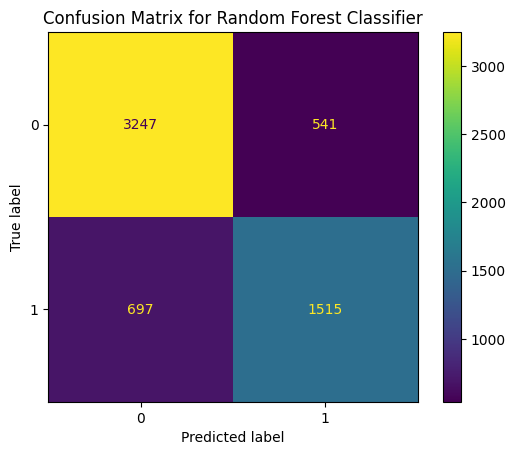

In [47]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm=confusion_matrix(y_test,preds_)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Random Forest Classifier')

Text(0.5, 1.0, 'Confusion Matrix for XGBoost Classifier')

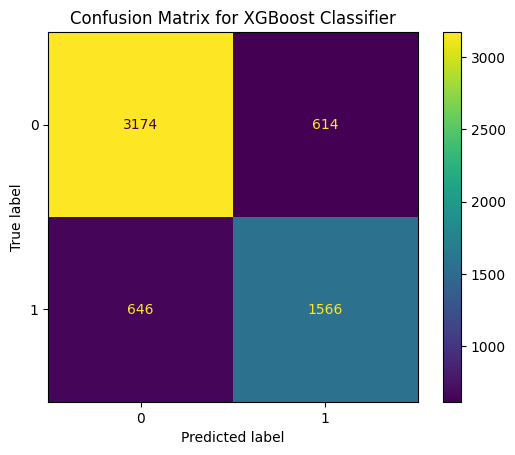

In [48]:
cm=confusion_matrix(y_test,preds)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix for XGBoost Classifier")

In [49]:
## False positive is more costly in this type of problems so RFC is better in terms of lesser false positives

In [51]:
final_df.to_csv('approach_3.csv')

In [ ]:
## Prediction Phase

In [52]:
import pickle

pickle.dump(rfc,open('approach_3_model.pkl','wb'))

In [53]:
x.shape,y.shape

((30000, 6022), (30000,))

In [70]:
def pipeline(q1,q2):

  model=pickle.load(open('approach_3_model.pkl','rb'))

  row = pd.Series({
        'question1': q1,
        'question2': q2
    })

  input_query=[]

  q1=preprocess(q1)
  q2=preprocess(q2)

  input_query.append(len(q1))
  input_query.append(len(q2))

  input_query.append(len(q1.split(" ")))
  input_query.append(len(q2.split(" ")))

  input_query.append(common_words(row))
  input_query.append(find_total_unique_words(row))
  input_query.append(common_words(row)/find_total_unique_words(row))


  ## token_features

  token_features=add_token_features(row)
  input_query.extend(token_features)

  ## length based features

  len_features=fetch_length_features(row)
  input_query.extend(len_features)

  ## fuzzy wuzzy features

  fuzzy_features=fetch_fuzzy_features(row)
  input_query.extend(fuzzy_features)

  ## applying the vectorization

  q1_vectorized=cv.transform([q1]).toarray()
  q2_vectorized=cv.transform([q2]).toarray()

  input=np.hstack((np.array(input_query).reshape(1,22),q1_vectorized,q2_vectorized))

  prediction=model.predict(input)[0]

  if prediction==1:
    return 'Duplicate Questions'
  else:
    return 'Non-duplicate Questions'

In [68]:
q1='where is the capital of india?'
q2='what is the current capital of india?'



In [69]:
pipeline(q1,q2)

np.int64(1)